# Calculation of control fields for QFT gate on two qubits using L-BFGS-B algorithm

Alexander Pitchford (agp1@aber.ac.uk)

Example to demonstrate using the control library to determine control
pulses using the ctrlpulseoptim.create_pulse_optimizer function to 
generate an Optimizer object, through which the configuration can be
manipulated before running the optmisation algorithm. In this case it is
demonstrated by modifying the initial ctrl pulses. Also re-uses objects in repeated runs with different total evolution times.

The (default) L-BFGS-B algorithm is used to optimise the pulse to
minimise the fidelity error, which is equivalent maximising the fidelity
to optimal value of 1.

The system in this example is two qubits in constant fields in x, y and z
with variable independant controls fields in x and y acting on each qubit
The target evolution is the QFT gate. The user can experiment with the
different:
 * evolution times - evo_times list values, try anything 
 * phase options - phase_option = SU or PSU
 *  propagtor computer type prop_type = DIAG or FRECHET
 *  fidelity measures - fid_type = UNIT or TRACEDIFF

The user can experiment with the timeslicing, by means of changing the
timeslots durations.
Different initial (starting) pulse types can be tried.
The initial and final pulses are displayed in a plot

This example assumes that the example-control-pulseoptim-Hadamard has already been tried, and hence explanations in that notebook are not repeated here.

In [391]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [392]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor, hadamard_transform
from qutip.qip.algorithms import qft
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen
from src.qutip_helper import convert_qutip_ham

from qiskit import IBMQ

example_name = 'QFT'

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Defining the physics

Note here that there are two controls acting on each qubit.

In [393]:
# Sx = sigmax()
# Sy = sigmay()
# Sz = sigmaz()
# Si = 0.5*identity(2)

# # Drift Hamiltonian
# H_d = 0.5*(tensor(Sx, Sx) + tensor(Sy, Sy) + tensor(Sz, Sz))
# # The (four) control Hamiltonians
# H_c = [tensor(Sx, Si), tensor(Sy, Si), tensor(Si, Sx), tensor(Si, Sy)]
# n_ctrls = len(H_c)
# # start point for the gate evolution
# U_0 = identity(4)
# # Target for the gate evolution - Quantum Fourier Transform gate
# U_targ = qft.qft(2)

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [394]:
# subsystem_list=[0,1]
subsystem_list=[0]
IBMQ.load_account()

# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
backend = provider.get_backend('ibmq_athens')
# backend.configuration().hamiltonian['vars']['wq0']
ham = convert_qutip_ham(backend, [0], False)
H_d = ham['H_d']
H_c = [ham['H_c']['D0']]

U_0 = identity(3)
# U_targ = Qobj([[0,1,0],
#                     [1,0,0],
#                     [0,0,1]])


n_ctrls = len(H_c)


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
ibmqfactory.load_account:WARNING:2020-09-01 12:23:23,673: Credentials are already in use. The existing account in the session will be replaced.


In [395]:
h = hadamard_transform(1).full()

hadamard_3 = Qobj([[h[0][0],h[0][1],0],
                   [h[1][0],h[1][1],0],
                   [0,      0,      1]])
U_targ = hadamard_3

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-395-faf2a7ad22a2>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  h = hadamard_transform(1).full()


In [396]:
hadamard_3

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.70710678  0.        ]
 [ 0.70710678 -0.70710678  0.        ]
 [ 0.          0.          1.        ]]

In [397]:
# print(backend.configuration().hamiltonian['h_latex'])
# backend.configuration().hamiltonian['vars']


/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


\begin{align} \mathcal{H}/\hbar = & \sum_{i=0}^{0}\left(\frac{\omega_{q,i}}{2}(\mathbb{I}-\sigma_i^{z})+\frac{\Delta_{i}}{2}(O_i^2-O_i)+\Omega_{d,i}D_i(t)\sigma_i^{X}\right) \\ \end{align}


### Defining the time evolution parameters

Multiple total evolution times will be tried. Using this approach, the minimum evolution time required to achieve the target fidelity could be determined (iteratively).

Note that the timeslot duration dt is fixed, and so the number of timeslots depends on the evo_time

In [398]:
# Duration of each timeslot
dt = backend.configuration().dt * 1e9
# dt = 0.02
n_ts = [160,320,512, 640, 800, 1280, 1600]
evo_times = [dt * n for n in n_ts]
# List of evolution times to try
# evo_times = [1, 3, 6]
n_evo_times = len(evo_times)
evo_time = evo_times[0]
n_ts = int(float(evo_time) / dt)
#Empty list that will hold the results for each evolution time
# results = list()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [399]:
real_dt = backend.configuration().dt
real_dt = real_dt * 1e9
real_dt
# real_dt * 320
dt

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.2222222222222222

### Set the conditions which will cause the pulse optimisation to terminate

In [400]:
# Fidelity error target
fid_err_targ = 1e-10
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 120
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Set the initial pulse type

Here the linear initial pulse type is used, simply because it results in smooth final pulses

In [401]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'LIN'

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Give an extension for output files

In [402]:
#Set to None to suppress output files
# f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)
f_ext = None

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create the optimiser objects

Here is the main difference between this and the Hadamard example. In this case we use a different pulseoptim function that just creates the objects that can be used to set the physics and configure the optimisation algorithm. This gives greater flexibility (shown here by seting different initial pulse parameters for each control) and is also more efficient when running multiple optimisations on the same system.

In [403]:
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                amp_lbound=-1.0, amp_ubound=1.0, 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                optim_method='fmin_l_bfgs_b',
                method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                dyn_type='UNIT', 
                fid_params={'phase_option':'PSU'},
                init_pulse_type=p_type, 
                log_level=log_level, gen_stats=True)

# **** get handles to the other objects ****
optim.test_out_files = 0
dyn = optim.dynamics
dyn.test_out_files = 0
p_gen = optim.pulse_generator
                

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Optimise the pulse for each of the different evolution times

Here a loop is used to perform the optimisation for each of the evo_times given in the list above. The first optimisation is completed using the timeslot parameters passed when the optimisation objects are created. For the subsequent runs, the Dynamics object 'dyn' is used to set the timeslot parameters before the initial pulses are generated and optimisation is completed. Note that using this method, the dyn.initialize_controls method must be called with an array of the initial amplitudes before the optim.run_optimization method is called.

In [404]:
results = []
for i in range(n_evo_times):
    # Generate the tau (duration) and time (cumulative) arrays
    # so that it can be used to create the pulse generator
    # with matching timeslots
    dyn.init_timeslots()
    if i > 0:
        # Create a new pulse generator for the new dynamics
        p_gen = pulsegen.create_pulse_gen(p_type, dyn)
        
    #Generate different initial pulses for each of the controls
    init_amps = np.zeros([n_ts, n_ctrls])
    if (p_gen.periodic):
        phase_diff = np.pi / n_ctrls
        for j in range(n_ctrls):
            init_amps[:, j] = p_gen.gen_pulse(start_phase=phase_diff*j)
    elif (isinstance(p_gen, pulsegen.PulseGenLinear)):
        for j in range(n_ctrls):
            p_gen.scaling = float(j) - float(n_ctrls - 1)/2
            init_amps[:, j] = p_gen.gen_pulse()
    elif (isinstance(p_gen, pulsegen.PulseGenZero)):
        for j in range(n_ctrls):
            p_gen.offset = sf = float(j) - float(n_ctrls - 1)/2
            init_amps[:, j] = p_gen.gen_pulse()
    else:
        # Should be random pulse
        for j in range(n_ctrls):
            init_amps[:, j] = p_gen.gen_pulse()
    
    dyn.initialize_controls(init_amps)
    
    # Save initial amplitudes to a text file
    if f_ext is not None:
        pulsefile = "ctrl_amps_initial_" + f_ext
        dyn.save_amps(pulsefile)
        print("Initial amplitudes output to file: " + pulsefile)

    print("***********************************")
    print("\n+++++++++++++++++++++++++++++++++++")
    print("Starting pulse optimisation for T={}".format(evo_time))
    print("+++++++++++++++++++++++++++++++++++\n")
    result = optim.run_optimization()
    results.append(result)

    # Save final amplitudes to a text file
    if f_ext is not None:
        pulsefile = "ctrl_amps_final_" + f_ext
        dyn.save_amps(pulsefile)
        print("Final amplitudes output to file: " + pulsefile)
    
    # Report the results
    result.stats.report()
    print("Final evolution\n{}\n".format(result.evo_full_final))
    print("********* Summary *****************")
    print("Final fidelity error {}".format(result.fid_err))
    print("Final gradient normal {}".format(result.grad_norm_final))
    print("Terminated due to {}".format(result.termination_reason))
    print("Number of iterations {}".format(result.num_iter))
    print("Completed in {} HH:MM:SS.US".format(
            datetime.timedelta(seconds=result.wall_time)))
    results.append(result)
    if i+1 < len(evo_times):
        # reconfigure the dynamics for the next evo time
        evo_time = evo_times[i+1]
        n_ts = int(float(evo_time) / dt)
        dyn.tau = None
        dyn.evo_time = evo_time
        dyn.num_tslots = n_ts

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.optimizer:Optimising pulse(s) using GRAPE with 'fmin_l_bfgs_b' method
***********************************

+++++++++++++++++++++++++++++++++++
Starting pulse optimisation for T=35.555555555555

In [420]:
results[2].evo_full_final
results[2].H_t

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'OptimResult' object has no attribute 'H_t'

### Plot the initial and final amplitudes

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


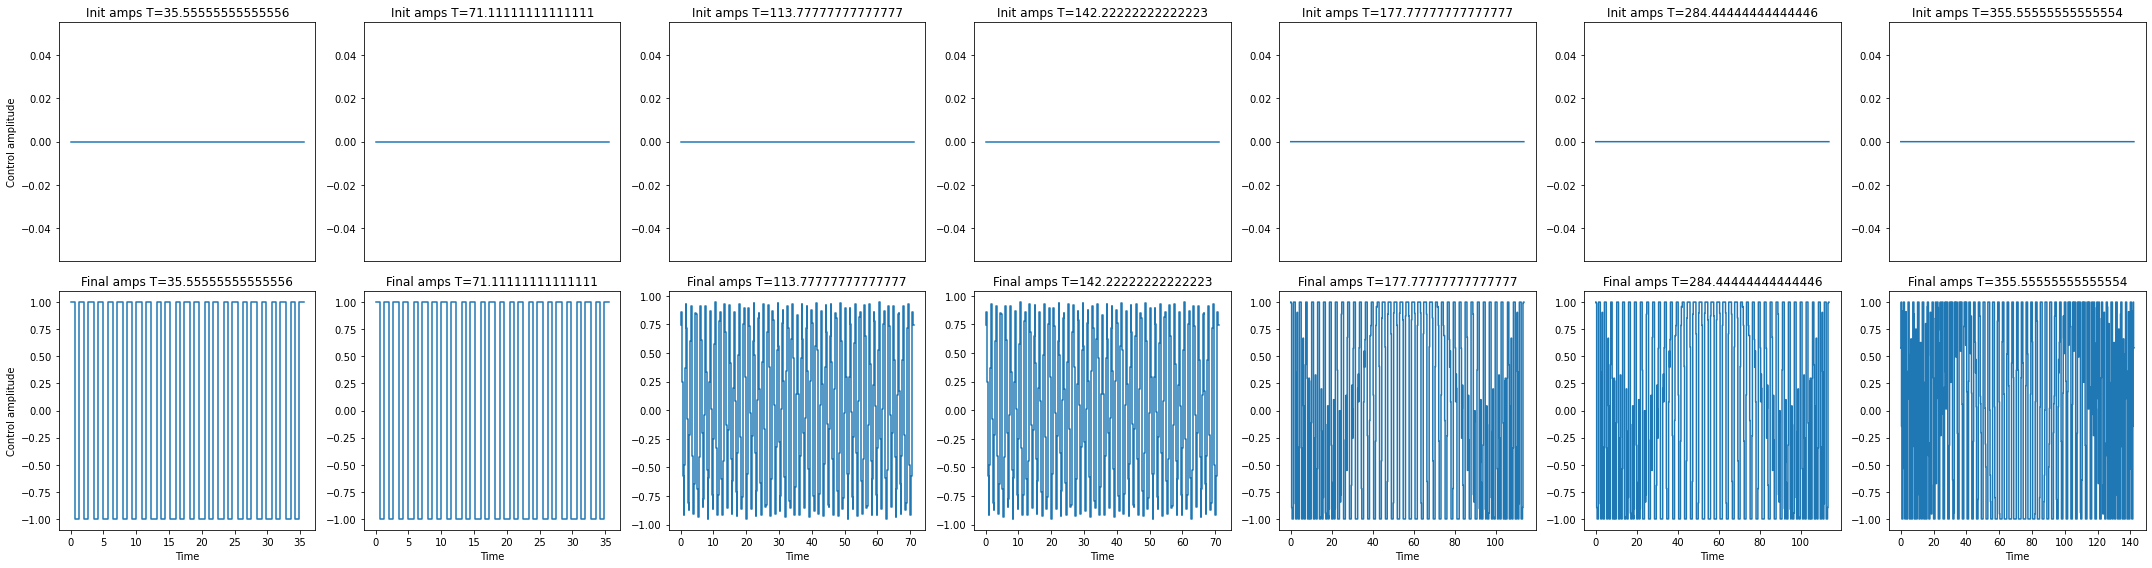

In [409]:
fig1 = plt.figure(figsize=(30,8))
for i in range(n_evo_times):
    #Initial amps
    ax1 = fig1.add_subplot(2, n_evo_times, i+1)
    ax1.set_title("Init amps T={}".format(evo_times[i]))
    # ax1.set_xlabel("Time")
    ax1.get_xaxis().set_visible(False)
    if i == 0:
        ax1.set_ylabel("Control amplitude")
    for j in range(n_ctrls):
        ax1.step(results[i].time, 
             np.hstack((results[i].initial_amps[:, j], 
                        results[i].initial_amps[-1, j])), 
                 where='post')
        
    ax2 = fig1.add_subplot(2, n_evo_times, i+n_evo_times+1)
    ax2.set_title("Final amps T={}".format(evo_times[i]))
    ax2.set_xlabel("Time")
    #Optimised amps
    if i == 0:
        ax2.set_ylabel("Control amplitude")
    for j in range(n_ctrls):
        ax2.step(results[i].time, 
             np.hstack((results[i].final_amps[:, j], 
                        results[i].final_amps[-1, j])), 
                 where='post')

plt.tight_layout()
plt.show()

### Versions

In [407]:
from qutip.ipynbtools import version_table

version_table()

/Users/benrosand/anaconda3/envs/qoc/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Software,Version
QuTiP,4.5.2
Numpy,1.19.1
SciPy,1.5.2
matplotlib,3.3.1
Cython,0.29.21
Number of CPUs,4
BLAS Info,Generic
IPython,7.17.0
Python,"3.8.5 | packaged by conda-forge | (default, Aug 21 2020, 18:05:02) [Clang 10.0.1 ]"
OS,posix [darwin]


In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi
from qutip.qip.device import Processor
from qutip.operators import sigmaz
from qutip.states import basis

processor = Processor(N=1)
processor.add_control(sigmaz(), targets=0)

tlist = np.linspace(0., 2*np.pi, 20)
tlist 
processor = Processor(N=1, spline_kind="step_func")
processor.add_control(sigmaz(), 0)
processor.pulses[0].tlist = tlist
processor.pulses[0].coeff = np.array([np.sin(t) for t in tlist])
processor.plot_pulses()

tlist = np.linspace(0., 2*np.pi, 20)
processor = Processor(N=1, spline_kind="cubic")
processor.add_control(sigmaz())
processor.pulses[0].tlist = tlist
processor.pulses[0].coeff =